# Configuration Systems in ssm-simulators

## Overview

This tutorial provides a comprehensive guide to the configuration systems in `ssm-simulators`. Understanding these configurations is essential for:

- Selecting and customizing models
- Controlling data generation pipelines
- Creating custom models (covered in Tutorial 05)

**What you'll learn:**
- The two configuration systems: `model_config` and `generator_config`
- How to access and modify existing configurations
- The nested structure of `generator_config`
- Best practices for configuration management

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# ssms imports
from ssms.config import model_config
from ssms.config.generator_config.data_generator_config import get_default_generator_config
from ssms.config import ConfigBuilder

## Introduction - Two Configuration Systems

The `ssm-simulators` package uses two complementary configuration systems:

### 1. `model_config` - Defines the Model

Specifies:
- Which SSM model (DDM, LBA, etc.)
- Parameters and their bounds
- Boundary functions
- Drift functions
- Parameter transforms

### 2. `generator_config` - Controls Data Generation

Specifies:
- How many parameter sets to sample
- Simulation settings (time resolution, number of samples)
- Estimator type (KDE vs PyDDM)
- Training data format
- Output options

```
┌─────────────────┐         ┌──────────────────┐
│  model_config   │────────▶│   Model Type     │
│                 │         │   Parameters     │
│   "What to      │         │   Bounds         │
│   simulate"     │         │   Functions      │
└─────────────────┘         └──────────────────┘

┌──────────────────┐        ┌──────────────────┐
│ generator_config │───────▶│   Pipeline       │
│                  │        │   Estimator      │
│   "Simulation  " │        │   Simulator      │
│   "to Training " │        │                  │
│   "Data "        │        │                  │
└──────────────────┘        └──────────────────┘
```

## `model_config` Deep Dive

### Basic Structure

Let's examine the structure of a typical `model_config`:

In [2]:
# Access the DDM config
ddm_config = model_config["ddm"]

print("DDM Configuration:")
print("=" * 50)
for key, value in ddm_config.items():
    if callable(value):
        print(f"{key}: <function {value.__name__}>")
    else:
        print(f"{key}: {value}")

DDM Configuration:
name: ddm
params: ['v', 'a', 'z', 't']
param_bounds: [[-3.0, 0.3, 0.1, 0.0], [3.0, 2.5, 0.9, 2.0]]
boundary_name: constant
boundary: <function constant>
boundary_params: []
n_params: 4
default_params: [0.0, 1.0, 0.5, 0.001]
nchoices: 2
choices: [-1, 1]
n_particles: 1
simulator: <function ddm_flexbound>
param_bounds_dict: {'v': (-3.0, 3.0), 'a': (0.3, 2.5), 'z': (0.1, 0.9), 't': (0.0, 2.0)}


**Core fields explained:**

- `name`: Model identifier
- `params`: List of parameter names
- `param_bounds`: Lower and upper bounds for each parameter
- `param_bounds_dict`: Dictionary version (easier for sampling)
- `nchoices`: Number of choices the model can produce
- `boundary`: Boundary function (if not constant)
- `n_params`: Number of parameters
- `default_params`: Default parameter values

In [3]:
# Let's look at a few different models
models_to_examine = ["ddm", "angle", "ornstein"]

for model_name in models_to_examine:
    config = model_config[model_name]
    print(f"\n{model_name.upper()}:")
    print(f"  Parameters: {config['params']}")
    print(f"  Choices: {config['nchoices']}")
    print(f"  Has custom boundary: {'boundary' in config and config.get('boundary') is not None}")


DDM:
  Parameters: ['v', 'a', 'z', 't']
  Choices: 2
  Has custom boundary: True

ANGLE:
  Parameters: ['v', 'a', 'z', 't', 'theta']
  Choices: 2
  Has custom boundary: True

ORNSTEIN:
  Parameters: ['v', 'a', 'z', 'g', 't']
  Choices: 2
  Has custom boundary: True


### Boundary Functions

Boundary functions define how decision thresholds behave over time. The package includes several built-in boundary types:

In [4]:
# Available boundary functions (from ssms.config._modelconfig.base)
from ssms.config._modelconfig.base import boundary_config as boundary_registry

print("Available Boundary Functions:")
print("=" * 60)
for name, config in boundary_registry.items():
    params_str = ", ".join(config["params"]) if config["params"] else "none"
    mult_str = "multiplicative" if config["multiplicative"] else "additive"
    print(f"{name:25} | params: {params_str:40} | {mult_str}")

Available Boundary Functions:
constant                  | params: none                                     | multiplicative
angle                     | params: theta                                    | additive
weibull_cdf               | params: alpha, beta                              | multiplicative
generalized_logistic      | params: B, M, v                                  | multiplicative
conflict_gamma            | params: theta, scale, alphaGamma, scaleGamma     | additive


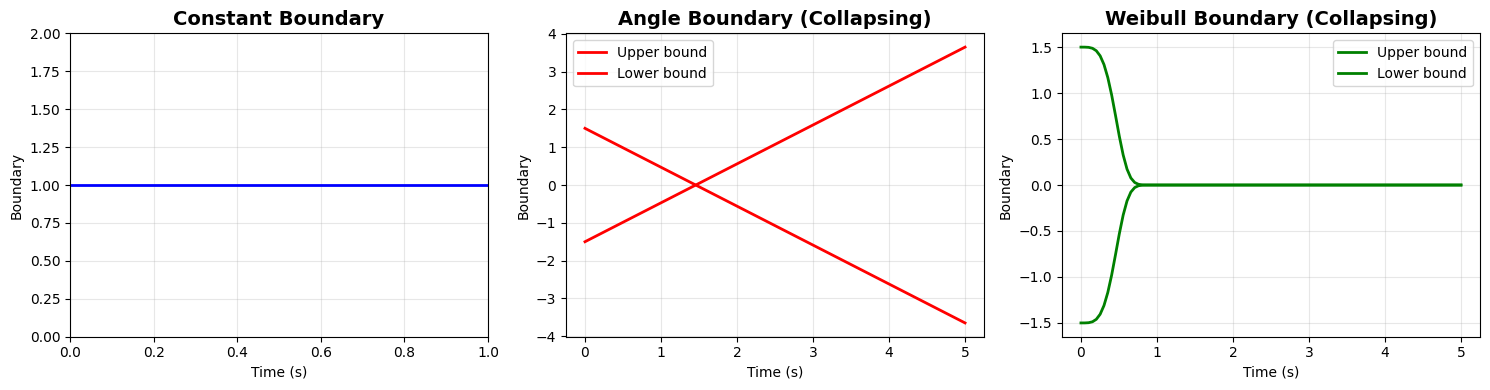


Note: Multiplicative boundaries scale with 'a' parameter, additive boundaries shift by 'a'.


In [5]:
# Visualize different boundary types
import ssms.basic_simulators.boundary_functions as bf

t = np.linspace(0, 5, 100)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Constant boundary
axes[0].axhline(y=1.0, color='blue', linewidth=2)
axes[0].set_title('Constant Boundary', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Boundary')
axes[0].set_ylim([0, 2])
axes[0].grid(alpha=0.3)

# Angle boundary (collapsing)
angle_vals = bf.angle(t, theta=0.8)
axes[1].plot(t, 1.5 + angle_vals, color='red', linewidth=2, label='Upper bound')
axes[1].plot(t, -1.5 - angle_vals, color='red', linewidth=2, label='Lower bound')
axes[1].set_title('Angle Boundary (Collapsing)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Boundary')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Weibull boundary
weibull_vals = bf.weibull_cdf(t, alpha=4.0, beta=0.5)
axes[2].plot(t, 1.5 * weibull_vals, color='green', linewidth=2, label='Upper bound')
axes[2].plot(t, -1.5 * weibull_vals, color='green', linewidth=2, label='Lower bound')
axes[2].set_title('Weibull Boundary (Collapsing)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylabel('Boundary')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: Multiplicative boundaries scale with 'a' parameter, additive boundaries shift by 'a'.")

### Drift Functions

Drift functions define how evidence accumulates over time. Most models use constant drift, but time-dependent drift is available:

In [6]:
# Available drift functions
from ssms.config._modelconfig.base import drift_config as drift_registry

print("Available Drift Functions:")
print("=" * 80)
for name, config in drift_registry.items():
    params_str = ", ".join(config["params"]) if config["params"] else "none"
    print(f"{name:40} | params: {params_str}")

Available Drift Functions:
constant                                 | params: none
gamma_drift                              | params: shape, scale, c
conflict_ds_drift                        | params: tinit, dinit, tslope, dslope, tfixedp, tcoh, dcoh
conflict_dsstimflex_drift                | params: tinit, dinit, tslope, dslope, tfixedp, tcoh, dcoh, tonset, donset
conflict_stimflex_drift                  | params: vt, vd, tcoh, dcoh, tonset, donset
conflict_stimflexrel1_drift              | params: vt, vd, tcoh, dcoh, tonset, donset
conflict_stimflexrel1_dual_drift         | params: vt, vd, tcoh, dcoh, tonset, donset, toffset, doffset
attend_drift                             | params: ptarget, pouter, pinner, r, sda
attend_drift_simple                      | params: ptarget, pouter, r, sda


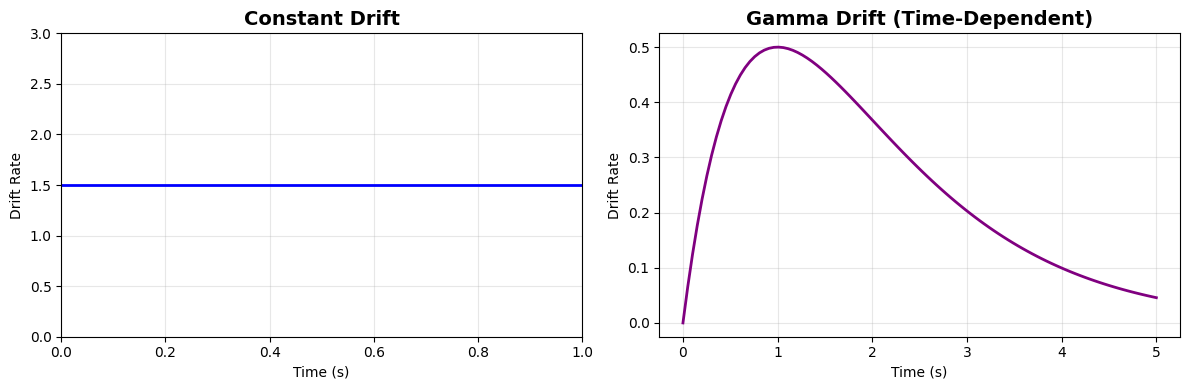

In [7]:
# Visualize constant vs time-dependent drift
import ssms.basic_simulators.drift_functions as df

t = np.linspace(0, 5, 100)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Constant drift
constant_drift_val = 1.5
axes[0].axhline(y=constant_drift_val, color='blue', linewidth=2)
axes[0].set_title('Constant Drift', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Drift Rate')
axes[0].set_ylim([0, 3])
axes[0].grid(alpha=0.3)

# Gamma drift (time-dependent)
gamma_vals = np.array([df.gamma_drift(t_i, shape=2.0, scale=1.0, c=0.5) for t_i in t])
axes[1].plot(t, gamma_vals, color='purple', linewidth=2)
axes[1].set_title('Gamma Drift (Time-Dependent)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Drift Rate')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Parameter Sampling Constraints

Parameter transforms are applied **after** sampling to enforce constraints or apply transformations. They're specified in the `parameter_sampling_constraints` field of `model_config`.

In [8]:
# Example: DDM with a > z constraint
ddm_with_constraint = model_config["ddm"].copy()

# Check if parameter_sampling_constraints exist
if "parameter_sampling_constraints" in ddm_with_constraint:
    print("Existing parameter transforms:")
    pprint(ddm_with_constraint["parameter_sampling_constraints"])
else:
    print("No parameter transforms defined for standard DDM.")
    print("\nWe can add them manually:")
    
# Add a swap transform to ensure a > z
ddm_with_constraint["parameter_sampling_constraints"] = [
    {"type": "swap", "param_a": "a", "param_b": "z"}
]

print("\nAdded transform:")
pprint(ddm_with_constraint["parameter_sampling_constraints"])

No parameter transforms defined for standard DDM.

We can add them manually:

Added transform:
[{'param_a': 'a', 'param_b': 'z', 'type': 'swap'}]


**Built-in transforms:**

1. **`swap`**: Swaps two parameters if the first is less than the second
   - Use case: Enforce `a > z` constraint
   - Config: `{"type": "swap", "param_a": "a", "param_b": "z"}`

2. **`normalize`**: Normalizes a list of parameters to sum to a value
   - Use case: Ensure drift rates sum to 1.0
   - Config: `{"type": "normalize", "param_names": ["v1", "v2", "v3"]}`

**Custom transforms** can be registered (see Tutorial 05 for details).

### Creating custom `model_config`

The `ConfigBuilder` class provides convenient methods for creating and modifying model configurations:

In [9]:
# Method 1: Start from an existing model and override
custom_ddm = ConfigBuilder.from_model(
    "ddm",
    param_bounds=[[-2.0, 0.5, 0.2, 0.0],  # Tighter bounds on v, a, z, t
                  [2.0, 2.0, 0.8, 1.5]]
)

print("Custom DDM with modified bounds:")
print(f"  Parameters: {custom_ddm['params']}")
print(f"  New bounds: {custom_ddm['param_bounds']}")

Custom DDM with modified bounds:
  Parameters: ['v', 'a', 'z', 't']
  New bounds: [[-2.0, 0.5, 0.2, 0.0], [2.0, 2.0, 0.8, 1.5]]


In [10]:
# Method 2: Add a custom boundary to an existing model
ddm_with_angle = ConfigBuilder.from_model("ddm")
ddm_with_angle = ConfigBuilder.add_boundary(
    ddm_with_angle,
    "angle",  # Boundary name from registry
)

print("\nDDM with angle (collapsing) boundary:")
print(f"  Parameters: {ddm_with_angle['params']}")
print(f"  Boundary: {ddm_with_angle.get('boundary_name', 'constant')}") 
if 'boundary_params' in ddm_with_angle:
    print(f"  Boundary params: {ddm_with_angle['boundary_params']}")


DDM with angle (collapsing) boundary:
  Parameters: ['v', 'a', 'z', 't']
  Boundary: angle
  Boundary params: ['theta']


In [11]:
# Method 3: Build from scratch (for completely custom models)
# Note: from_scratch requires a simulator_function (covered in Tutorial 05)
# For now, let's show an alternative: creating a custom variant of DDM

my_custom_model = ConfigBuilder.from_model(
    "ddm",
    param_bounds=[[-3.0, 0.5, 0.1, 0.0],  # Custom bounds
                  [3.0, 2.5, 0.9, 1.0]],
)
# Rename it to make it clear it's custom
my_custom_model["name"] = "my_custom_ddm"

print("\nCustom DDM variant:")
print(f"  Name: {my_custom_model['name']}")
print(f"  Parameters: {my_custom_model['params']}")
print(f"  Bounds: {my_custom_model['param_bounds']}")
print("\nNote: For completely new models with custom simulator functions,")
print("see Tutorial 05 for full details on using ConfigBuilder.from_scratch()")


Custom DDM variant:
  Name: my_custom_ddm
  Parameters: ['v', 'a', 'z', 't']
  Bounds: [[-3.0, 0.5, 0.1, 0.0], [3.0, 2.5, 0.9, 1.0]]

Note: For completely new models with custom simulator functions,
see Tutorial 05 for full details on using ConfigBuilder.from_scratch()


In [12]:
# Validate a configuration
is_valid, errors = ConfigBuilder.validate_config(my_custom_model, strict=False)

if is_valid:
    print("\n✓ Configuration is valid!")
else:
    print("\n✗ Configuration has errors:")
    for error in errors:
        print(f"  - {error}")


✓ Configuration is valid!


## `generator_config` Deep Dive

### The Nested Structure

The `generator_config` uses a nested structure to organize settings into logical sections:

In [13]:
# Get default LAN config
lan_config = get_default_generator_config("lan")

print("generator_config structure:")
print("=" * 60)
for section in lan_config.keys():
    print(f"\n[{section}]")
    if isinstance(lan_config[section], dict):
        for key, value in lan_config[section].items():
            # Truncate long values for display
            if isinstance(value, dict) and len(str(value)) > 50:
                print(f"  {key}: {{...}}")
            else:
                print(f"  {key}: {value}")
    else:
        print(f"  {lan_config[section]}")

generator_config structure:

[pipeline]
  n_parameter_sets: 10000
  n_subruns: 10
  n_cpus: all
  n_parameter_sets_rejected: 100

[estimator]
  type: kde
  displace_t: False

[training]
  mixture_probabilities: [0.8, 0.1, 0.1]
  n_samples_per_param: 1000
  separate_response_channels: False
  negative_rt_cutoff: -66.77497

[simulator]
  delta_t: 0.001
  max_t: 20.0
  n_samples: 100000
  smooth_unif: True
  filters: {...}

[output]
  folder: data/lan_mlp/
  pickle_protocol: 4
  nbins: 0

[model]
  ddm

[bin_pointwise]
  False


### Section-by-Section Breakdown

Let's examine each section in detail:

#### Pipeline Section

Controls the overall data generation workflow:

In [14]:
print("Pipeline Settings:")
print("=" * 60)
pprint(lan_config["pipeline"])

print("\n" + "=" * 60)
print("Key Parameters:")
print("  n_parameter_sets: How many parameter combinations to sample")
print("  n_subruns: Number of parallel batches (for large jobs)")
print("  n_cpus: CPU allocation ('all' or integer)")
print("  n_parameter_sets_rejected: Buffer for rejection sampling")

Pipeline Settings:
{'n_cpus': 'all',
 'n_parameter_sets': 10000,
 'n_parameter_sets_rejected': 100,
 'n_subruns': 10}

Key Parameters:
  n_parameter_sets: How many parameter combinations to sample
  n_subruns: Number of parallel batches (for large jobs)
  n_cpus: CPU allocation ('all' or integer)
  n_parameter_sets_rejected: Buffer for rejection sampling


#### Estimator Section

Controls how likelihoods are estimated:

In [15]:
print("Estimator Settings:")
print("=" * 60)
pprint(lan_config["estimator"])

print("\n" + "=" * 60)
print("Key Parameters:")
print("  type: 'kde' (simulation-based) or 'pyddm' (analytical)")
print("  bandwidth: KDE bandwidth (only for type='kde')")
print("  displace_t: Whether to displace time for KDE")
print("  use_pyddm_pdf: Use PyDDM for PDF computation (type='pyddm')")
print("  pdf_interpolation: 'linear' or 'cubic' (type='pyddm')")
print("  max_undecided_prob: Reject if P(undecided) > threshold (type='pyddm')")

Estimator Settings:
{'displace_t': False, 'type': 'kde'}

Key Parameters:
  type: 'kde' (simulation-based) or 'pyddm' (analytical)
  bandwidth: KDE bandwidth (only for type='kde')
  displace_t: Whether to displace time for KDE
  use_pyddm_pdf: Use PyDDM for PDF computation (type='pyddm')
  pdf_interpolation: 'linear' or 'cubic' (type='pyddm')
  max_undecided_prob: Reject if P(undecided) > threshold (type='pyddm')


#### Training Section

Controls training data generation:

In [16]:
print("Training Settings:")
print("=" * 60)
pprint(lan_config["training"])

print("\n" + "=" * 60)
print("Key Parameters:")
print("  mixture_probabilities: Data augmentation [full_trials, single_rt, single_choice]")
print("  n_samples_per_param: Training samples per parameter set")
print("  separate_response_channels: Choice-conditional formatting")
print("  n_subdatasets: Split into multiple datasets (optional)")
print("  n_trials_per_dataset: Trials per subdataset (optional)")

Training Settings:
{'mixture_probabilities': [0.8, 0.1, 0.1],
 'n_samples_per_param': 1000,
 'negative_rt_cutoff': -66.77497,
 'separate_response_channels': False}

Key Parameters:
  mixture_probabilities: Data augmentation [full_trials, single_rt, single_choice]
  n_samples_per_param: Training samples per parameter set
  separate_response_channels: Choice-conditional formatting
  n_subdatasets: Split into multiple datasets (optional)
  n_trials_per_dataset: Trials per subdataset (optional)


#### Simulator Section

Controls simulation behavior:

In [17]:
print("Simulator Settings:")
print("=" * 60)
pprint(lan_config["simulator"])

print("\n" + "=" * 60)
print("Key Parameters:")
print("  delta_t: Time step size (smaller = more accurate, slower)")
print("  max_t: Maximum simulation time")
print("  n_samples: Number of simulation trials per parameter set")
print("  smooth_unif: Uniform noise smoothing")
print("  filters: Quality filters (reject poor simulations)")

Simulator Settings:
{'delta_t': 0.001,
 'filters': {'choice_cnt': 0,
             'mean_rt': 17,
             'mode': 20,
             'mode_cnt_rel': 0.95,
             'std': 0},
 'max_t': 20.0,
 'n_samples': 100000,
 'smooth_unif': True}

Key Parameters:
  delta_t: Time step size (smaller = more accurate, slower)
  max_t: Maximum simulation time
  n_samples: Number of simulation trials per parameter set
  smooth_unif: Uniform noise smoothing
  filters: Quality filters (reject poor simulations)


In [18]:
# Examine simulation filters
print("\nSimulation Filters:")
print("=" * 60)
if "filters" in lan_config["simulator"]:
    for filter_name, threshold in lan_config["simulator"]["filters"].items():
        print(f"  {filter_name}: {threshold}")
    print("\nFilters ensure simulation quality by rejecting parameter sets with:")
    print("  - mode: RT mode at boundary")
    print("  - choice_cnt: Too few samples for a choice")
    print("  - mean_rt: Mean RT too high")
    print("  - std: Non-positive standard deviation")
    print("  - mode_cnt_rel: Mode contains too many samples")


Simulation Filters:
  mode: 20
  choice_cnt: 0
  mean_rt: 17
  std: 0
  mode_cnt_rel: 0.95

Filters ensure simulation quality by rejecting parameter sets with:
  - mode: RT mode at boundary
  - choice_cnt: Too few samples for a choice
  - mean_rt: Mean RT too high
  - std: Non-positive standard deviation
  - mode_cnt_rel: Mode contains too many samples


#### Output Section

Controls output format and location:

In [19]:
print("Output Settings:")
print("=" * 60)
pprint(lan_config["output"])

print("\n" + "=" * 60)
print("Key Parameters:")
print("  folder: Output directory")
print("  pickle_protocol: Serialization version (4 is standard)")
print("  nbins: Number of bins for RT histograms (0 = no binning)")
print("  negative_rt_cutoff: Cutoff for log-RT transformation")

Output Settings:
{'folder': 'data/lan_mlp/', 'nbins': 0, 'pickle_protocol': 4}

Key Parameters:
  folder: Output directory
  pickle_protocol: Serialization version (4 is standard)
  nbins: Number of bins for RT histograms (0 = no binning)
  negative_rt_cutoff: Cutoff for log-RT transformation


### Getting Default Configs

The package provides default configurations for different use cases:

In [20]:
# LAN config (simulation-based, KDE estimator)
lan_config = get_default_generator_config("lan")
print("LAN Config:")
print(f"  Estimator type: {lan_config['estimator']['type']}")
print(f"  Parameter sets: {lan_config['pipeline']['n_parameter_sets']}")
print(f"  Samples per param: {lan_config['training']['n_samples_per_param']}")

# PyDDM config (analytical PDFs)
pyddm_config = get_default_generator_config("lan")
pyddm_config["estimator"]["type"] = "pyddm"
print("\nPyDDM Config:")
print(f"  Estimator type: {pyddm_config['estimator']['type']}")
print(f"  Parameter sets: {pyddm_config['pipeline']['n_parameter_sets']}")
print(f"  Samples per param: {pyddm_config['training']['n_samples_per_param']}")

LAN Config:
  Estimator type: kde
  Parameter sets: 10000
  Samples per param: 1000

PyDDM Config:
  Estimator type: pyddm
  Parameter sets: 10000
  Samples per param: 1000


## Config Validation

### Using ConfigBuilder Validation

Always validate your custom configurations to catch errors early:

In [21]:
# Create a valid config
valid_config = ConfigBuilder.from_model("ddm")

is_valid, errors = ConfigBuilder.validate_config(valid_config, strict=False)
print("Valid Config Test:")
print(f"  Is valid: {is_valid}")
print(f"  Errors: {errors if errors else 'None'}")

Valid Config Test:
  Is valid: True
  Errors: None


In [22]:
# Create an invalid config (missing required field)
invalid_config = {
    "name": "incomplete_model",
    "params": ["v", "a"],
    # Missing param_bounds!
}

is_valid, errors = ConfigBuilder.validate_config(invalid_config, strict=False)
print("\nInvalid Config Test:")
print(f"  Is valid: {is_valid}")
if errors:
    print("  Errors:")
    for error in errors:
        print(f"    - {error}")


Invalid Config Test:
  Is valid: False
  Errors:
    - Missing required field: 'nchoices'
    - Missing required field: 'simulator'
